<a href="https://colab.research.google.com/github/jjrodcast/MaskDectector/blob/master/MaskDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Face Mask Detector



#### 1. Cargamos librerías

In [12]:
!pip install mtcnn
from mtcnn import MTCNN
import numpy as np
import tensorflow as tf
import tensorflow.keras
import torch
from PIL import Image
import cv2
import timeit
import matplotlib.pyplot as plt
from utils.bounding_box import resizeBoundingBox
from utils.predictor_keras import predict
from utils.detect_faces import detect_faces, detect_faces_with_mask

#### 2. Variables de configuración

In [0]:
IMG_WIDTH = 160 # Ancho de la imagen
IMG_HEIGHT = 160 # Alto de la imagen
BBOX_PERCENTAGE = 0.05 # Porcentage de ampliación del bounding box
CONFIDENCE = 0.7 # Porcentage de confidencia del detector de rostros
classes = ['no_mask', 'mask'] # Clases de la capa final

#### 3. Carga de imagen original

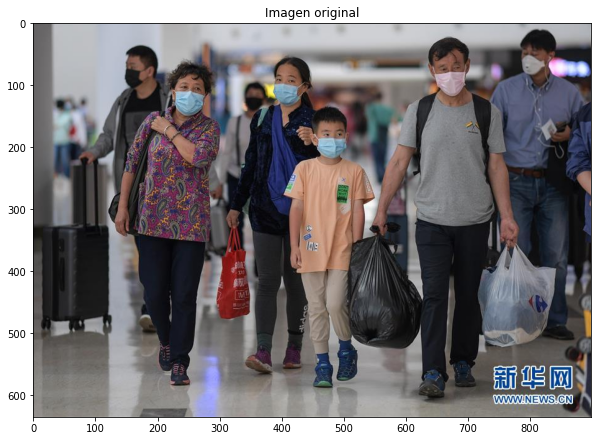

In [14]:
img = cv2.imread('multimedia/test4.jpg')
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.title("Imagen original")
plt.imshow(img_color)
plt.show()

#### 4. Cargamos modelo detector de rostros

In [0]:
# Detector de rostros (Multi-Task Cascaded Convolutional Neural Network)
face_detector = MTCNN()

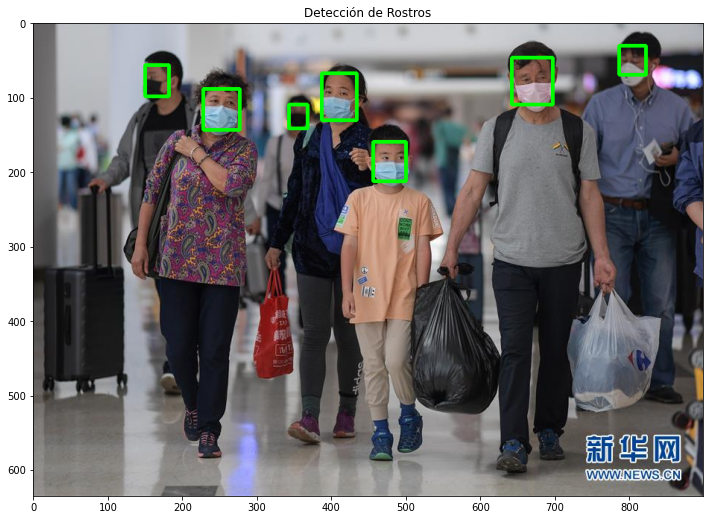

In [16]:
# Verificamos la detección de rostros
image_detected = detect_faces(img_color, face_detector, confidence=CONFIDENCE, target_size=(IMG_WIDTH, IMG_HEIGHT))
plt.figure(figsize=(12, 12))
plt.title('Detección de Rostros')
plt.imshow(image_detected)
plt.show()

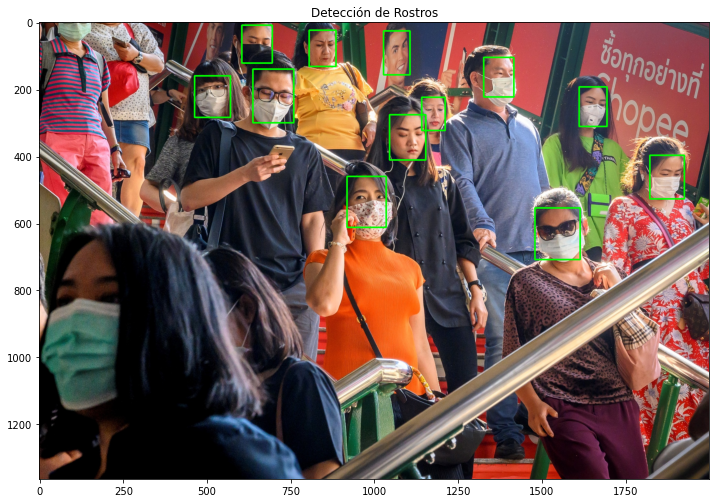

In [17]:
# Probamos sobre otra imagen
img_test = cv2.imread('multimedia/test3.jpg')
img_color_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
image_detected2 = detect_faces(img_color_test, face_detector, confidence=CONFIDENCE, target_size=(IMG_WIDTH, IMG_HEIGHT))
plt.figure(figsize=(12, 12))
plt.title('Detección de Rostros')
plt.imshow(image_detected2)
plt.show()

####5. Detección de Mascarillas en Imágenes

##### 5.1. Usando Clasificador de Rostros con Keras

El modelo usado con Keras fue entrenado desde cero.

In [0]:
# Detector de mascaras (MaskNet)
model_keras = tf.keras.models.load_model('models/mask_net.hdf5')

###### 5.1.1. Detectamos si las personas tienen mascarillas

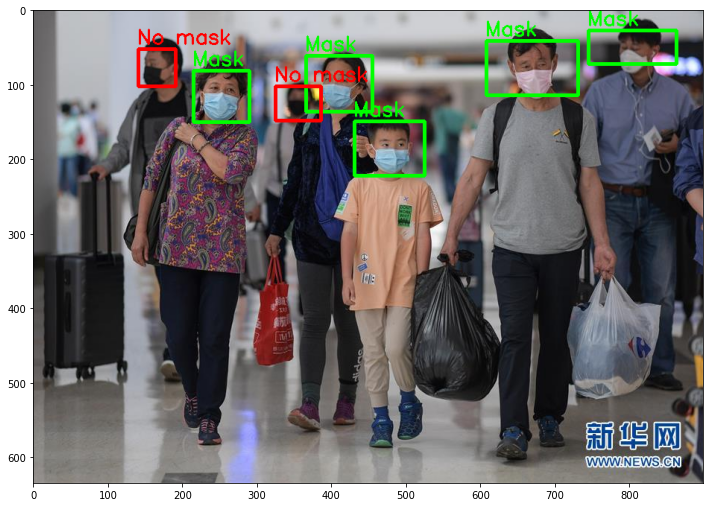

In [19]:
image_mask_detection = detect_faces_with_mask(img_color, face_detector, model_keras, classes, 
                                   CONFIDENCE, bbox_percentage=0.05, predictor='keras', 
                                   target_size=(IMG_WIDTH, IMG_HEIGHT))

plt.figure(figsize=(12, 12))
plt.imshow(image_mask_detection)
plt.show()

##### 5.2. Usando clasificador PyTorch

En el modelo de PyTorch se usó Transfer Learning usando ResNet18

In [0]:
model_torch = torch.load('models/best_model_conv_ft2.model')

###### 5.2.1. Detectamos si la persona tiene mascarillas

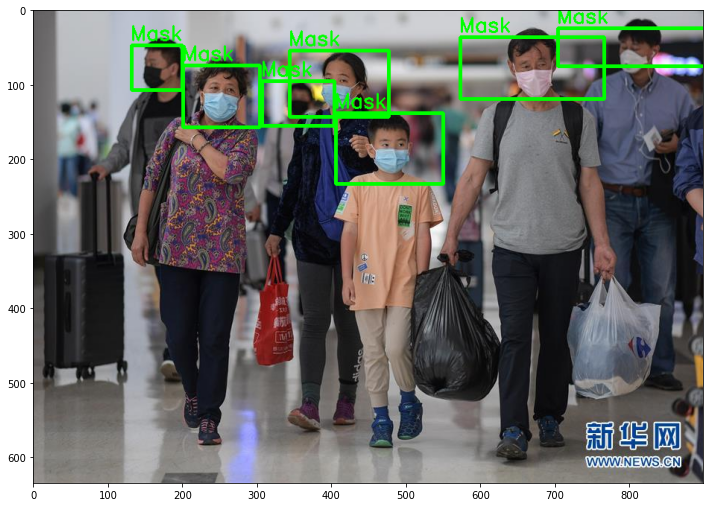

In [21]:
image_mask_detection = detect_faces_with_mask(img_color, face_detector, model_torch, ['mask', 'no_mask'], 
                                              CONFIDENCE, bbox_percentage=0.1, predictor='torch', 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT))

plt.figure(figsize=(12, 12))
plt.imshow(image_mask_detection)
plt.show()

#### 6. Detección de Mascarillas en Video

In [0]:
video = cv2.VideoCapture('multimedia/video_test_1.mp4')
W = None
H = None
writer = None

while True:
  _, frame = video.read()

  if frame is None:
    break

  if W is None or H is None:
    (H, W) = frame.shape[:2]

	# Inicializar el writer
  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter('multimedia/output_video.mp4', fourcc, 30, (W, H), True)

  img_color = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  img_color_temp = detect_faces_with_mask(img_color, face_detector, model_keras,
                                          classes, CONFIDENCE, 0.5, predictor='keras',
                                          target_size=(IMG_WIDTH, IMG_HEIGHT))
  if writer is not None:
    writer.write(img_color_temp[:,:,::-1])      

if writer is not None:
  writer.release()

video.release()